# Homework 5 (Tymoteusz Makowski)
### Tasks description
1. For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)
1. calculate permutational variable importance for the selected model,
1. train three or more candidate models (different variables, different transformations, different model structures) and compare ranking of important features between these models. Are they similar or different?
1. Comment on the results for points (2) and (3)

## Ad task 2

The selected data set contains historic prices per square meter of apartments in Warsaw. The model of choices was random forest implemented in R's `randomForest` package. I have decided to not use any hyperparameters of the model.

The feature importance plot attached below clearly shows that *by far* the most important variable is `district`. This is generally aligned with the domain knowledge. The apartments prices are highly correlated with the district they are in. For instance, apartments in Wilanów district are considered more prestigious than apartments in Ursus district. Additionally, the district is tightly tied to the public communication or various other points of interest which can affect the square meter's price. For example, districts close to the metro or the old town will have higher price per square meter than districts on the outskirts of the city. All of this leads to the model getting lots of information from this variable which can easily differentiate apartments.

The third most important variables, `floor`, can yield valuable information about the apartments price. Usually, the higher floor the apartment will be more pricey which possibly allows model to perform better predictions.

However, the `surface` being second most important goes against my knowledge on the subject. Usually, the surface is not correlated to the price per square meter due to lower demand for big apartments which due to that can have lower price per square meter than the smaller apartments. Perhaps this variable is correlated to the `district` variable, e.g. the more presigious districts having bigger apartments.

The lesser importance of the last two variables, `construction.year` and `no.rooms`, can be easily explained that neither of those features are crucial on the property market. Quite often the number of rooms can be changed by modifying the apartment's wall layout. Additioally, construction year importance is often overshadowed by the location which has much more contribution to price per square meter.

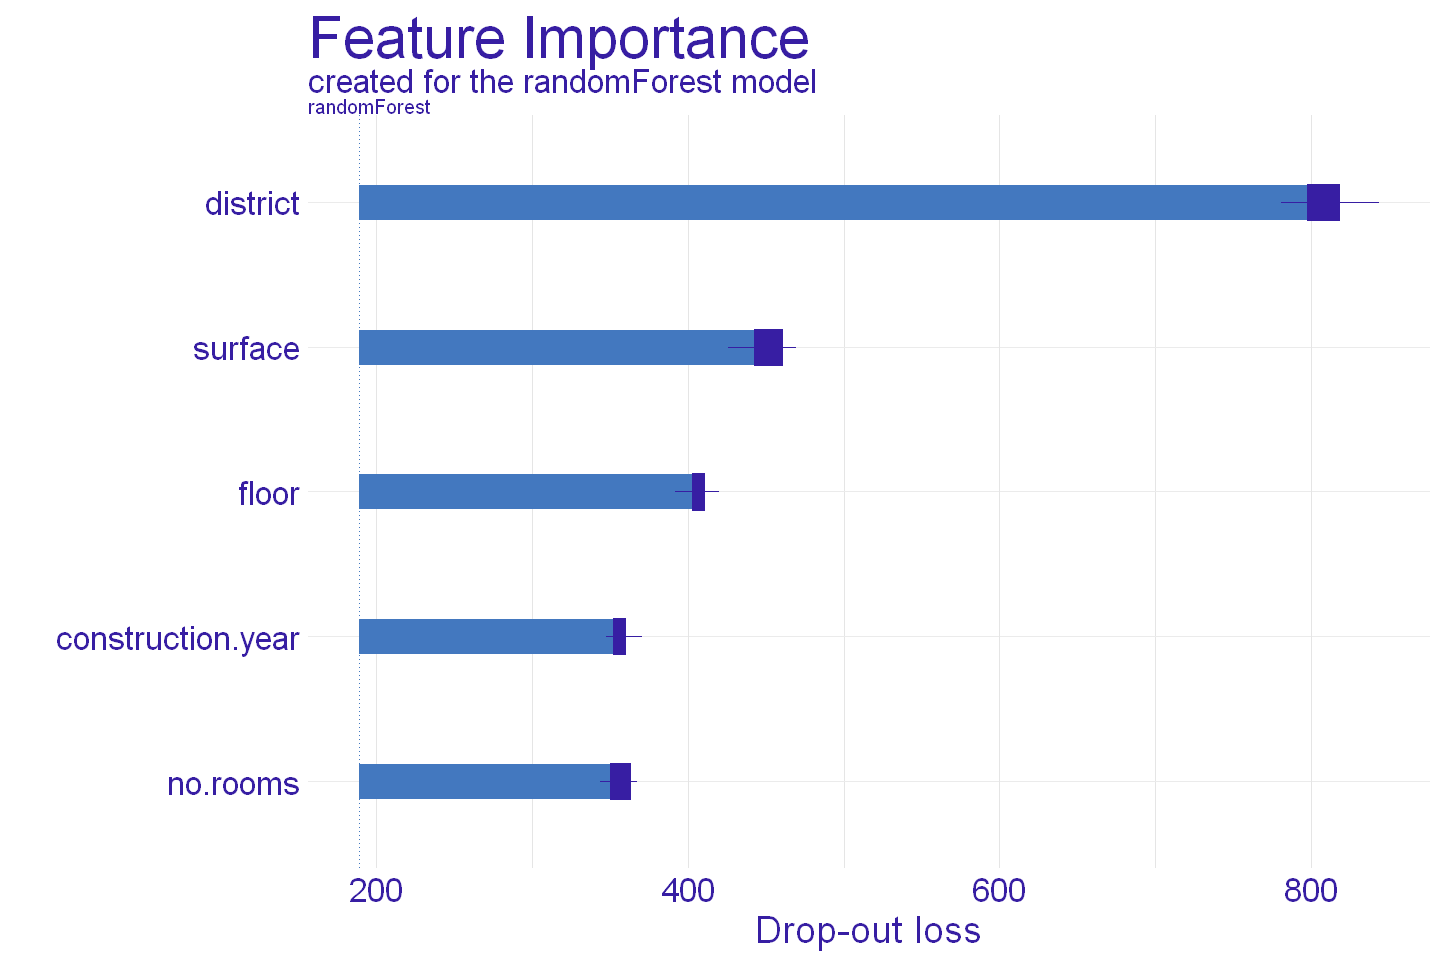

In [22]:
task2_plot

## Ad task 3

In this task I have performed additional three approaches to this problem's modelling. The first one was dropping the `district` variable in the random forest model to see how variable importance changes when we leave out the most important variable. The second and third approaches relied on using different models on unaltered data. Those models were svm and linear regression model respectively.

The three plots shown below represent variable importance of these three approaches.

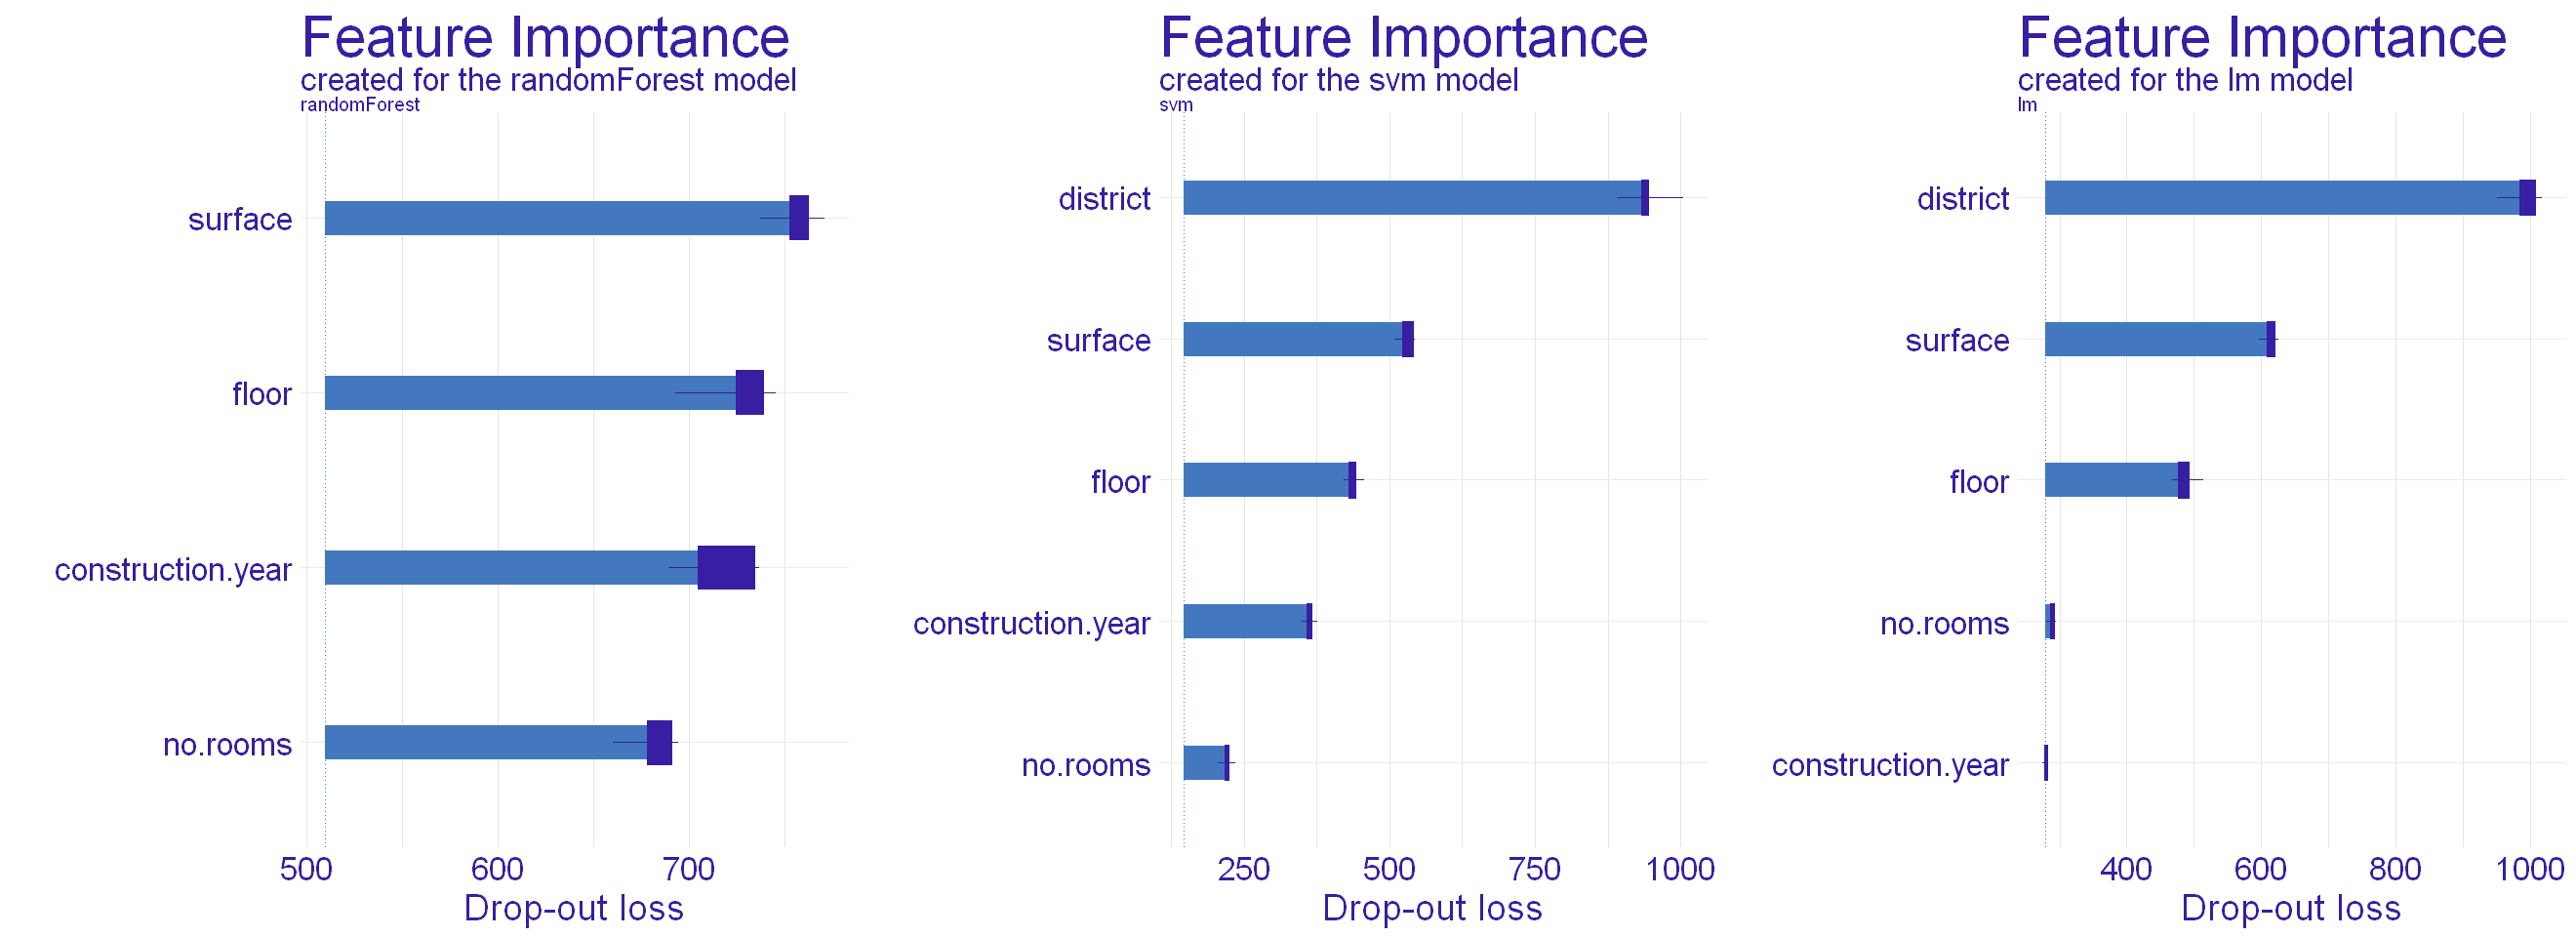

In [23]:
options(repr.plot.width = 22)
grid.arrange(task3v1_plot, task3v2_plot, task3v3_plot, ncol = 3)

Looking at these plots two things immediately stand out. The first being much more balanced feature importance for the random forest model and the second one being linear model higly dominated by one of the variables. The second one is obviously aligned with intuition - since the `district` variable is generally the most important one then the linear model is highly dependent on it, casting away the two variables which tend to be the least important ones (`construction.year` and `no.rooms`).

The svm model also has more diffrentiated distribution of the feature importance. The `no.rooms` variable appears to yield almost four times lesser drop-out loss than the `district` variable where even the linear model has only about 2.5 times the difference. Overall the distribution of the variables importance haven't changed much. Each of the used models - random forest, svm and linear model - seem to follow the same pattern of `district` being by far the most important variable, followed by the `surface` which is close to the third most important variable - `floor`, and two least important variables being `construction.year` and `no.rooms` whose order changes between different models.

Finally, there is the case where I have left out the `district` variable for the random forest model. This caused model to perform worse - relative root mean squared error rose from 7.94% to 20.06%. Additionally, this change caused all of the variables to have higher drop-out loss. Most likely due to each variable providing relatively more crucial information to the model than where the `district` variable was present. Moreover, all the variables are closer together when it comes to drop-out loss, meaning that the model is being provided with similar amount of information from each of these variables.

## Appendix

In [1]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(jupyter.rich_display = FALSE)
options(width = 120)

In [2]:
library("randomForest")
library("DALEX")
library("ggplot2")
library("e1071")
library("gridExtra")


increase_plot_font_size <- function(g, font_size = 20) {
    g + theme(
        text = element_text(size = font_size),
        axis.text = element_text(size = font_size),
        axis.title = element_text(size = font_size+3),
        plot.title = element_text(size = font_size + 15)
    )
}


print_loss <- function(model, X, y) {
    rms <- loss_root_mean_square(
        y,
        predict(model, X)
    )
    cat(
        sprintf(
            "RMSE: %s\nMean: %s\nRelative RMSE: %s%%",
            round(rms, 2),
            round(mean(y), 2),
            round(rms / mean(y) * 100, 2)
        )
    )
}

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Welcome to DALEX (version: 1.2.0).
Find examples and detailed introduction at: https://pbiecek.github.io/ema/



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin



Attaching package: 'gridExtra'


The following object is masked from 'package:randomForest':

    combine




### Task 1

In [3]:
data <- apartments
data_test <- apartments_test

X_train <- data[, -1]
y_train <- data[, 1]

X_test <- data_test[, -1]
y_test <- data_test[, 1]

In [4]:
rf <- randomForest(x = X_train, y = y_train)
rf


Call:
 randomForest(x = X_train, y = y_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 77938.95
                    % Var explained: 90.51

In [5]:
print_loss(rf, X_test, y_test)

RMSE: 280.22
Mean: 3511.52
Relative RMSE: 7.98%

### Task 2

In [6]:
explainer <- explain(rf, data = X_train, y = y_train)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  1000  rows  5  cols 
  -> target variable   :  1000  values 
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  numerical, min =  1941.481 , mean =  3487.685 , max =  5874.429  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -370.6779 , mean =  -0.6657129 , max =  851.4201  
  A new explainer has been created!  


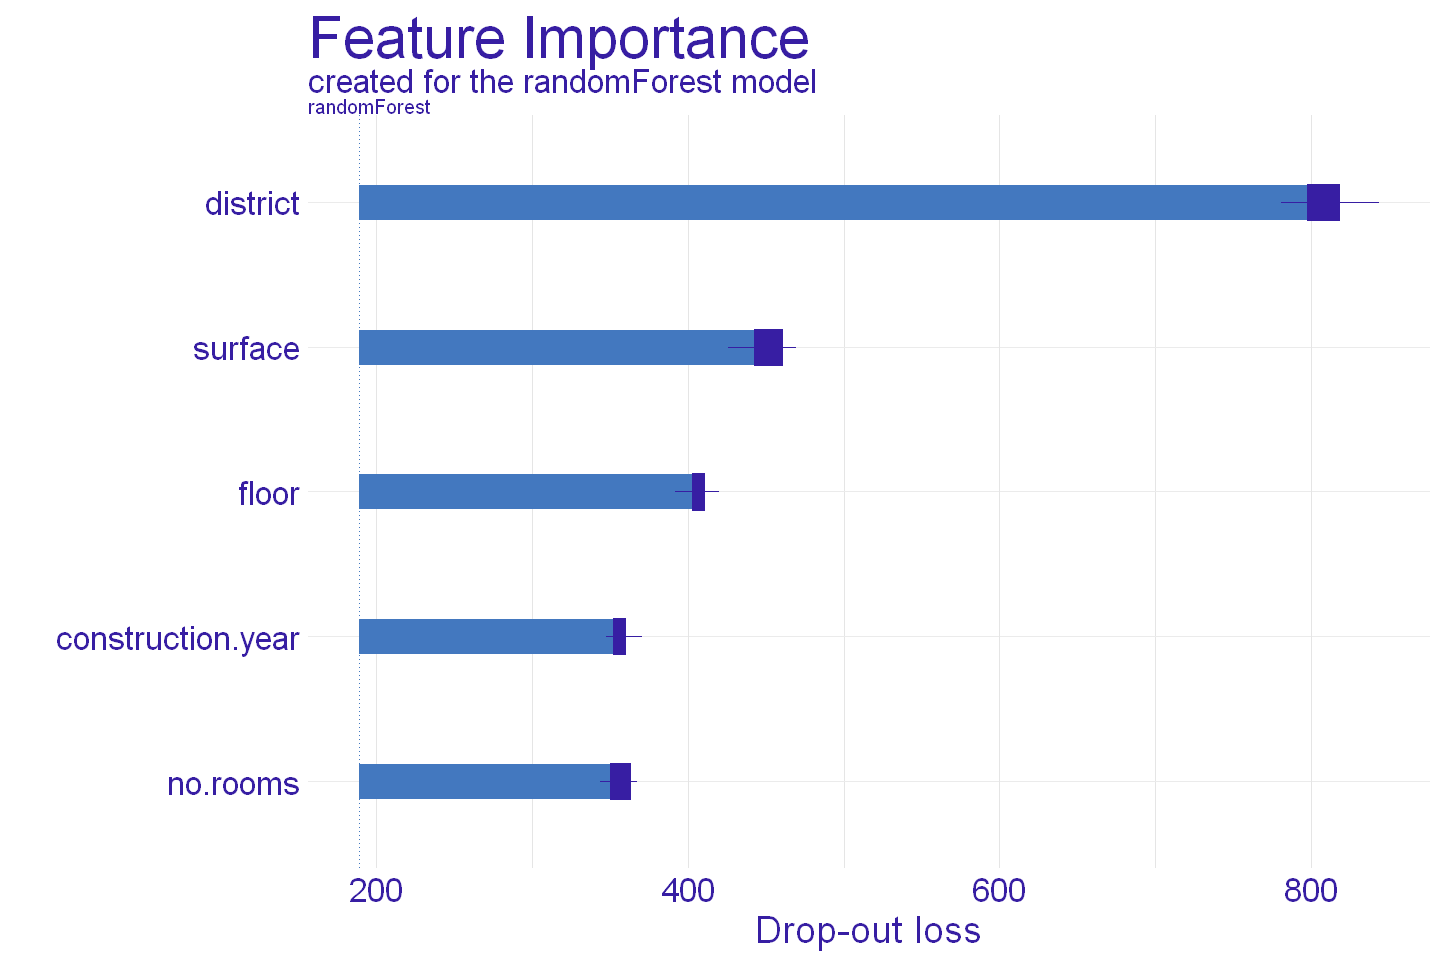

In [7]:
vi <- variable_importance(explainer, loss_function = loss_root_mean_square)
task2_plot <- increase_plot_font_size(plot(vi))
task2_plot

### Task 3

#### V1: Excluding `district` variable

In [8]:
X_train3v1 <- X_train[, -5]
X_test3v1 <- X_test[, -5]

##### Model

In [9]:
m3v1 <- randomForest(x = X_train3v1, y = y_train)
m3v1


Call:
 randomForest(x = X_train3v1, y = y_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 488049.2
                    % Var explained: 40.57

In [10]:
print_loss(m3v1, X_test3v1, y_test)

RMSE: 705.24
Mean: 3511.52
Relative RMSE: 20.08%

##### Explainer

In [11]:
explainer3v1 <- explain(m3v1, data = X_train3v1, y = y_train)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  1000  rows  4  cols 
  -> target variable   :  1000  values 
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  numerical, min =  2092.844 , mean =  3488.947 , max =  5321.848  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -735.7502 , mean =  -1.927792 , max =  1500.675  
  A new explainer has been created!  


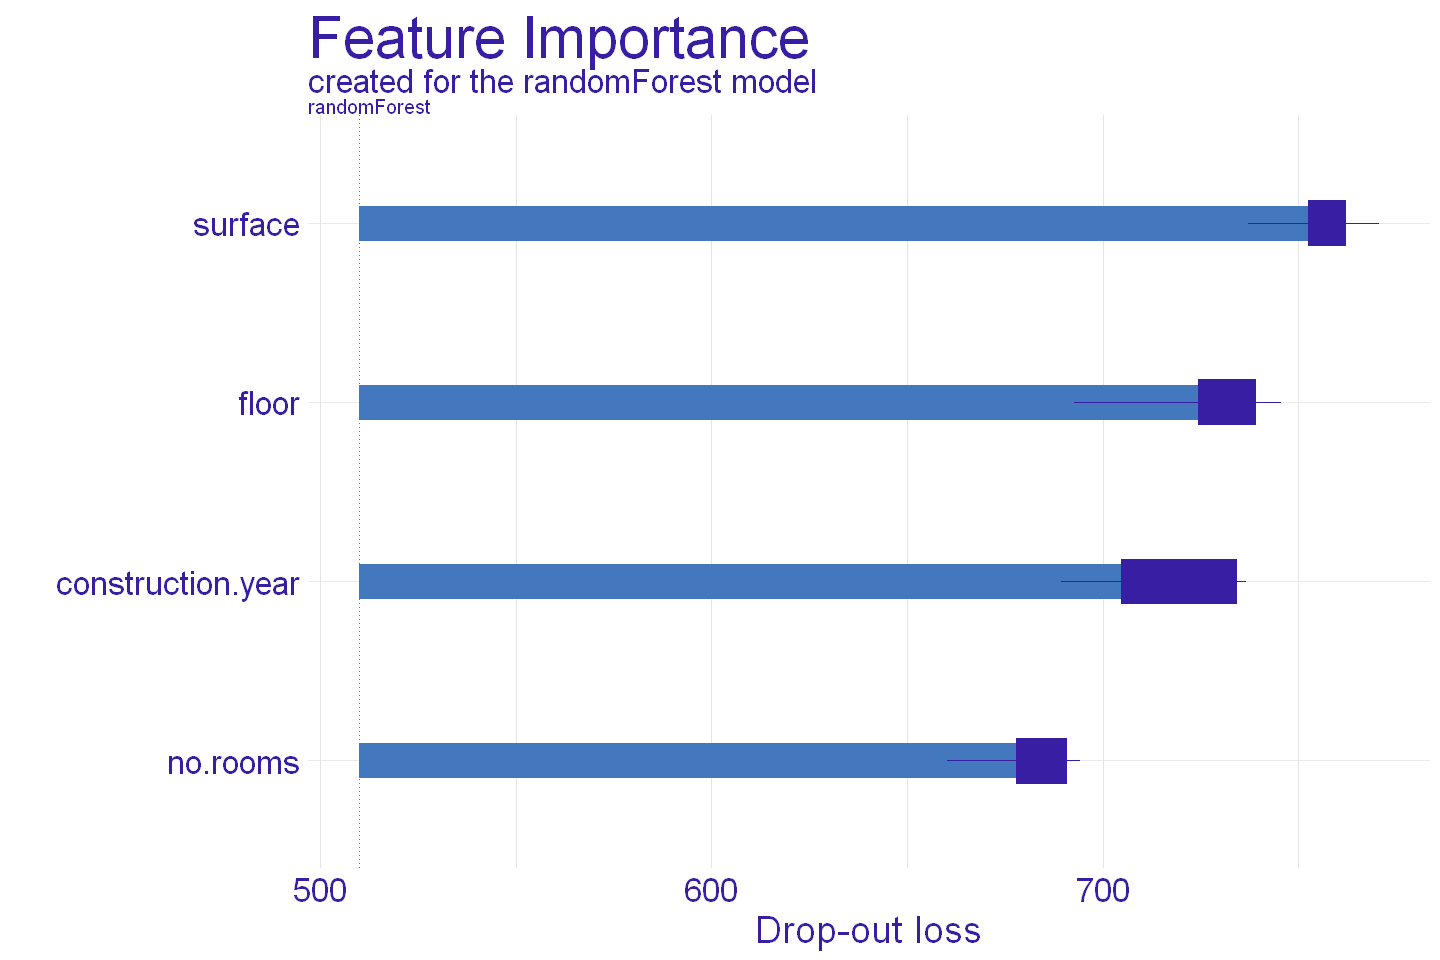

In [12]:
vi3v1 <- variable_importance(explainer3v1, loss_function = loss_root_mean_square)
task3v1_plot <- increase_plot_font_size(plot(vi3v1))
task3v1_plot

#### V2

In [13]:
svm_train <- X_train
svm_train["y"] <- y_train

##### Model

In [14]:
m3v2 <- svm(y ~ ., data = svm_train)
m3v2


Call:
svm(formula = y ~ ., data = svm_train)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.07142857 
    epsilon:  0.1 


Number of Support Vectors:  536


In [15]:
print_loss(m3v2, X_test, y_test)

RMSE: 160.9
Mean: 3511.52
Relative RMSE: 4.58%

##### Explainer

In [16]:
explainer3v2 <- explain(m3v2, data = X_train, y = y_train)

Preparation of a new explainer is initiated
  -> model label       :  svm  (  default  )
  -> data              :  1000  rows  5  cols 
  -> target variable   :  1000  values 
  -> model_info        :  package e1071 , ver. 1.7.3 , task regression (  default  ) 
  -> predict function  :  yhat.svm  will be used (  default  )
  -> predicted values  :  numerical, min =  1757.663 , mean =  3481.819 , max =  6225.354  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -424.0007 , mean =  5.200121 , max =  639.5637  
  A new explainer has been created!  


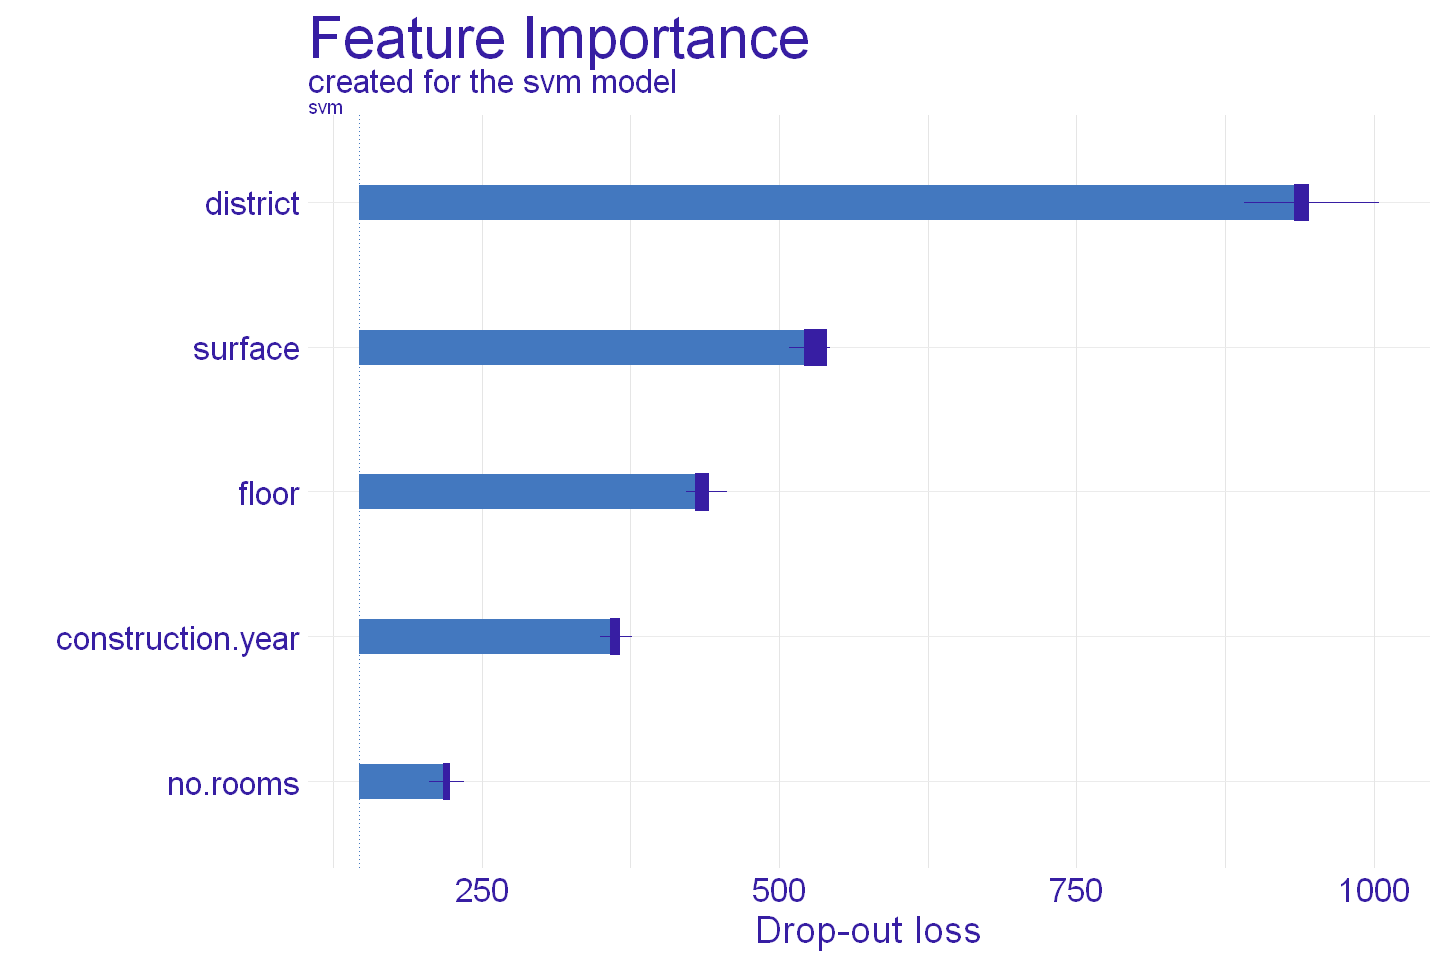

In [17]:
vi3v2 <- variable_importance(explainer3v2, loss_function = loss_root_mean_square)
task3v2_plot <- increase_plot_font_size(plot(vi3v2))
task3v2_plot

#### V3

##### Model

In [18]:
m3v3 <- lm(y ~ ., data = svm_train)
m3v3


Call:
lm(formula = y ~ ., data = svm_train)

Coefficients:
        (Intercept)    construction.year              surface                floor             no.rooms  
           5020.139               -0.229              -10.238              -99.482              -37.730  
    districtBielany      districtMokotow       districtOchota        districtPraga  districtSrodmiescie  
             17.214              918.380              926.254              -37.105             2080.611  
      districtUrsus      districtUrsynow         districtWola     districtZoliborz  
             29.942              -18.865              -16.891              889.973  


In [19]:
print_loss(m3v3, X_test, y_test)

RMSE: 283.09
Mean: 3511.52
Relative RMSE: 8.06%

##### Explainer

In [20]:
explainer3v3 <- explain(m3v3, data = X_train, y = y_train)

Preparation of a new explainer is initiated
  -> model label       :  lm  (  default  )
  -> data              :  1000  rows  5  cols 
  -> target variable   :  1000  values 
  -> model_info        :  package stats , ver. 3.6.3 , task regression (  default  ) 
  -> predict function  :  yhat.lm  will be used (  default  )
  -> predicted values  :  numerical, min =  1781.848 , mean =  3487.019 , max =  6176.032  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -247.4728 , mean =  2.093656e-14 , max =  469.0023  
  A new explainer has been created!  


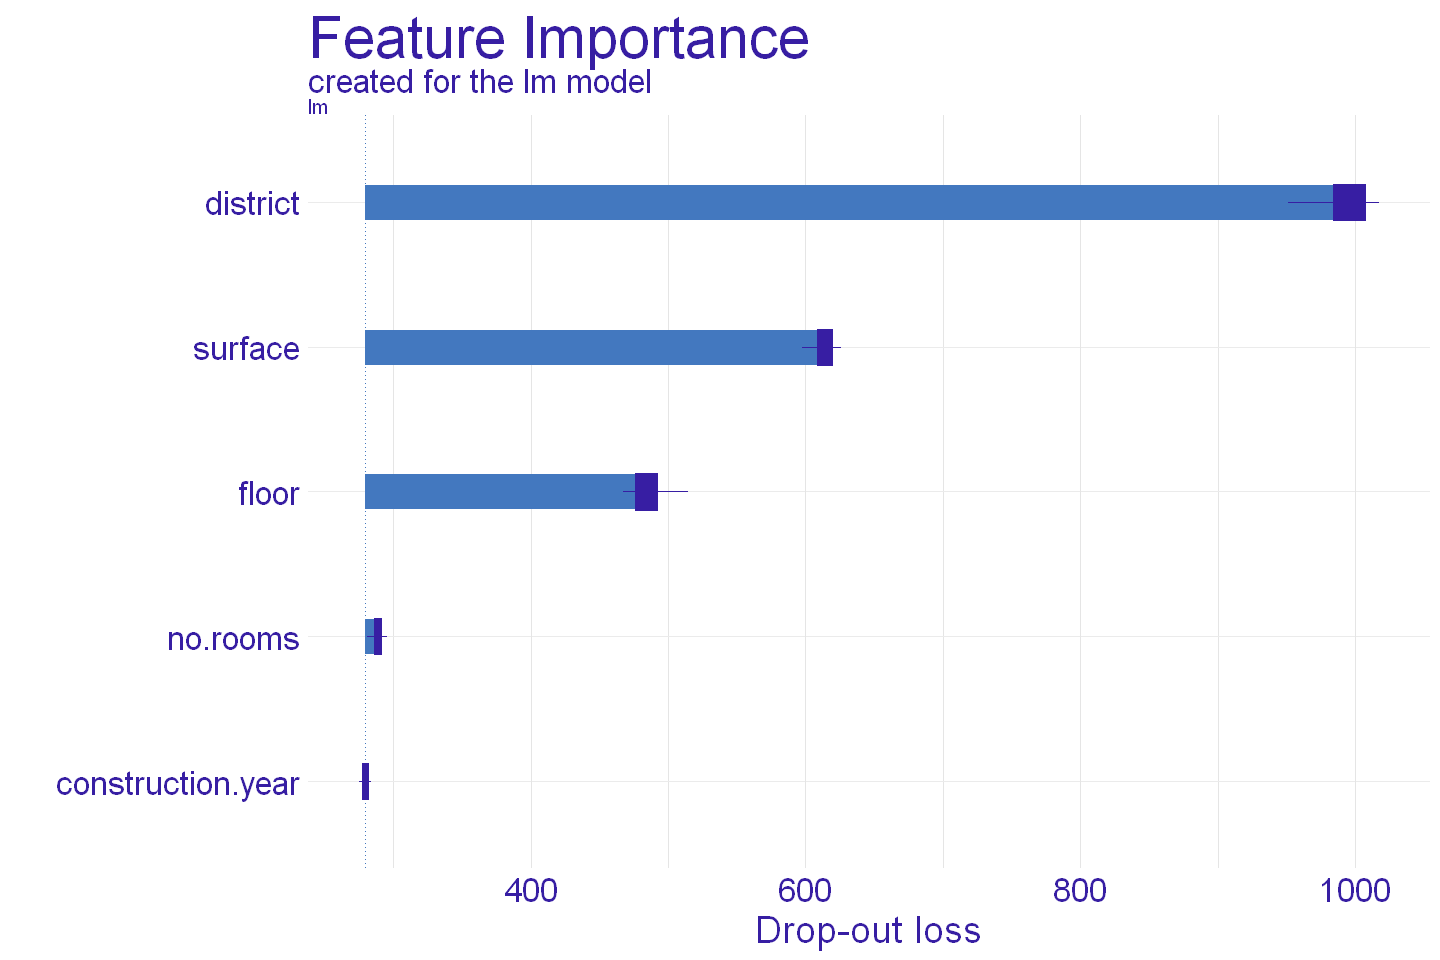

In [21]:
vi3v3 <- variable_importance(explainer3v3, loss_function = loss_root_mean_square)
task3v3_plot <- increase_plot_font_size(plot(vi3v3))
task3v3_plot